In [1]:
!nvidia-smi

Fri Dec 12 10:24:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0  On |                  Off |
|  0%   57C    P8             35W /  450W |     101MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !/opt/conda/bin/pip install torch
# !/opt/conda/bin/pip install torchvision

In [3]:
# [Cell 1] 데이터 추출 및 준비
import os
import glob
import zipfile
import shutil

# 1. 경로 설정 (로컬 환경)
drive_root = '/home/jovyan/work/metaorganic/Validation'
src_dir = os.path.join(drive_root, '01.원천데이터')
lbl_dir = os.path.join(drive_root, '02.라벨링데이터')

# 2. 저장할 임시 폴더 초기화
dest_root = '/home/jovyan/work/metaorganic/data'
dest_img_dir = os.path.join(dest_root, 'images')
dest_json_dir = os.path.join(dest_root, 'jsons')

if os.path.exists(dest_root): shutil.rmtree(dest_root)
os.makedirs(dest_img_dir, exist_ok=True)
os.makedirs(dest_json_dir, exist_ok=True)

# 3. 균형 잡힌 데이터 추출 함수
def extract_balanced_samples(limit_per_zip=50):
    print("데이터 추출 시작...")
    src_zips = glob.glob(os.path.join(src_dir, '*.zip'))
    total_count = 0

    for src_zip in src_zips:
        filename = os.path.basename(src_zip)
        lbl_filename = filename.replace('VS_', 'VL_')
        lbl_zip = os.path.join(lbl_dir, lbl_filename)

        if not os.path.exists(lbl_zip): continue

        try:
            with zipfile.ZipFile(src_zip, 'r') as z_src, zipfile.ZipFile(lbl_zip, 'r') as z_lbl:
                img_files = [f for f in z_src.namelist() if f.lower().endswith(('.jpg', '.png'))]
                img_files.sort()

                count = 0
                for img_file in img_files:
                    if count >= limit_per_zip: break

                    basename = os.path.basename(img_file)
                    json_name = basename.replace('.jpg', '.json').replace('.png', '.json')

                    try:
                        matching_json = next(n for n in z_lbl.namelist() if os.path.basename(n) == json_name)

                        with z_src.open(img_file) as source, open(os.path.join(dest_img_dir, basename), "wb") as target:
                            shutil.copyfileobj(source, target)
                        with z_lbl.open(matching_json) as source, open(os.path.join(dest_json_dir, json_name), "wb") as target:
                            shutil.copyfileobj(source, target)
                        count += 1
                    except StopIteration: continue

                print(f"   {filename}: {count}장 추출")
                total_count += count
        except Exception as e: print(f"   오류: {e}")

    print(f"총 {total_count}개 데이터 준비 완료!")

# 실행 (Zip당 500개씩 추출)
extract_balanced_samples(limit_per_zip=500)

데이터 추출 시작...
   VS_01.딸기_001.설향_05.황화.zip: 500장 추출
   VS_01.딸기_001.설향_02.역병.zip: 500장 추출
   VS_01.딸기_001.설향_03.시들음병.zip: 500장 추출
   VS_01.딸기_001.설향_01.정상.zip: 500장 추출
   VS_01.딸기_001.설향_04.잎끝마름.zip: 500장 추출
총 2500개 데이터 준비 완료!


In [4]:
%%writefile dataset.py
import json
import random
import numpy as np
import torch
import os
import glob
from torch.utils.data import Dataset
from PIL import Image, ImageEnhance
from tqdm import tqdm

# ==========================================
# 질병 클래스 매핑 (전체 5개)
# ==========================================
DISEASE_CLASS_MAP = {
    '정상': 0,
    '잎끝마름': 1,  # 팁번 (Tip-burn)
    '황화': 2,
    '역병': 3,
    '시들음병': 4
}

DISEASE_NAMES = ['정상', '잎끝마름(팁번)', '황화', '역병', '시들음병']
NUM_CLASSES = len(DISEASE_CLASS_MAP)

# ==========================================
# 1. 데이터 생성기 (NPK 수치 생성)
# ==========================================
class DataGenerator:
    def __init__(self):
        # 기존 통계값 (백업용)
        self.stats = {
            'Healthy': {
                'N': (175.2, 8.5),
                'P': (120.0, 3.3),
                'K': (240.1, 3.3)
            },
            'Deficient_N': (80.0, 20.0),
            'Deficient_P': (60.0, 10.0),
            'Deficient_K': (120.0, 20.0),
            'Excess': (220.0, 10.0)
        }

    def generate_targets_from_growth(self, growth_index, disease_class):
        """
        생육 지표 기반 NPK 생성 (연속적 분포)

        Args:
            growth_index: JSON의 growth_index 딕셔너리
            disease_class: 질병 클래스 ID (0-4)

        Returns:
            [N, P, K] 리스트
        """
        # 생육 지표 추출 (문자열을 float로 변환)
        try:
            leaf_cnt = float(growth_index.get('leaf_cnt') or 5)
            leaf_width = float(growth_index.get('leaf_width') or 8)
            leaf_length = float(growth_index.get('leaf_length') or 10)
            stem_length = float(growth_index.get('stem_length') or 30)
        except (ValueError, TypeError):
            leaf_cnt, leaf_width, leaf_length, stem_length = 5, 8, 10, 30

        # 생육 점수 계산 (잎 면적 기반, 0~1 범위)
        leaf_area = leaf_cnt * leaf_width * leaf_length
        # 일반적인 딸기 잎 면적 범위: 200~1200 정도
        growth_score = np.clip(leaf_area / 1000.0, 0.2, 1.0)

        # 줄기 길이도 반영 (길수록 생육 좋음)
        stem_factor = np.clip(stem_length / 50.0, 0.5, 1.2)
        growth_score *= stem_factor

        # 기본 NPK 값 (생육 점수 기반 연속 분포)
        N = 60 + growth_score * 120    # 60~180 범위
        P = 40 + growth_score * 80     # 40~120 범위
        K = 100 + growth_score * 150   # 100~250 범위

        # 질병에 따라 특정 영양소 감소 (30~70% 수준으로)
        deficiency_factor = 0.3 + random.random() * 0.4  # 0.3~0.7

        if disease_class == 2:      # 황화 → N(질소) 결핍
            N *= deficiency_factor
        elif disease_class == 1:    # 잎끝마름 → K(칼륨) 결핍
            K *= deficiency_factor
        elif disease_class == 3:    # 역병 → P(인) 결핍
            P *= deficiency_factor

        # 약간의 노이즈 추가 (더 자연스러운 분포)
        N += random.gauss(0, 8)
        P += random.gauss(0, 5)
        K += random.gauss(0, 10)

        # 최소값 보장
        return [max(20.0, N), max(15.0, P), max(50.0, K)]

    def generate_targets(self, label_type):
        """기존 방식 (백업용)"""
        n_stat = self.stats['Healthy']['N']
        p_stat = self.stats['Healthy']['P']
        k_stat = self.stats['Healthy']['K']

        if label_type == 'Deficient_N':
            n_stat = self.stats['Deficient_N']
        elif label_type == 'Deficient_P':
            p_stat = self.stats['Deficient_P']
        elif label_type == 'Deficient_K':
            k_stat = self.stats['Deficient_K']

        n = max(10.0, np.random.normal(n_stat[0], n_stat[1]))
        p = max(10.0, np.random.normal(p_stat[0], p_stat[1]))
        k = max(10.0, np.random.normal(k_stat[0], k_stat[1]))

        return [n, p, k]

# ==========================================
# 2. 데이터셋 클래스 (NPK + 질병 분류)
# ==========================================
class StrawberryDataset(Dataset):
    def __init__(self, json_files, img_root_dir, transform=None):
        self.img_root_dir = img_root_dir
        self.transform = transform
        self.generator = DataGenerator()

        print("이미지 경로 인덱싱 중...")
        self.image_map = {}
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
            for path in glob.glob(os.path.join(img_root_dir, '**', ext), recursive=True):
                self.image_map[os.path.basename(path)] = path

        self.samples = []
        print(f"데이터 로딩 중... (총 {len(json_files)}개)")

        # 클래스별 카운트
        class_counts = {i: 0 for i in range(NUM_CLASSES)}

        for j_file in tqdm(json_files):
            try:
                with open(j_file, 'r', encoding='utf-8') as f:
                    raw = json.load(f)
                if isinstance(raw, list): raw = raw[0]

                # 이미지 정보 추출 (images 필드에서)
                images_info = raw.get('images', {})
                img_name = images_info.get('fname', '')
                if not img_name:
                    img_name = os.path.basename(j_file).replace('.json', '.jpg')
                full_img_path = self.image_map.get(img_name)

                # ★ disease_class는 'images' 필드에 있음 ★
                d_code = images_info.get('disease_class', '정상')
                if not d_code:
                    d_code = '정상'

                # 질병 클래스 ID 결정
                disease_class = 0  # 기본값: 정상
                for keyword, class_id in DISEASE_CLASS_MAP.items():
                    if keyword in d_code:
                        disease_class = class_id
                        break

                class_counts[disease_class] += 1

                # 환경 데이터
                try:
                    env = raw.get('environments', [{}])[0]
                    real_env = [
                        float(env.get('ti_value', 25.0)), float(env.get('hi_value', 60.0)),
                        float(env.get('ci_value', 400.0)), float(env.get('el_value', 1.0)),
                        float(env.get('pi_value', 6.0))
                    ]
                except:
                    real_env = [25.0, 60.0, 400.0, 1.0, 6.0]

                # ★★★ 생육 지표 기반 NPK 생성 (연속적 분포) ★★★
                growth_index = raw.get('growth_index', {})
                npk_vals = self.generator.generate_targets_from_growth(growth_index, disease_class)

                gas_vec = [0.5, 0.1, 10.0]

                self.samples.append({
                    'img_path': full_img_path,
                    'input_vec': real_env + gas_vec,
                    'target_vec': [v/300.0 for v in npk_vals],
                    'disease_class': disease_class,
                    'growth_score': growth_index  # 디버깅용
                })

            except Exception as e:
                continue

        print(f"\n데이터셋 준비 완료!")
        print(f"클래스 분포:")
        for cls_id, count in class_counts.items():
            print(f"  - {DISEASE_NAMES[cls_id]}: {count}개")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = sample['img_path']

        try:
            image = Image.open(img_path).convert('RGB') if img_path else Image.new('RGB', (224, 224))
        except:
            image = Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)

        input_tensor = torch.tensor(sample['input_vec'], dtype=torch.float32)
        target_npk = torch.tensor(sample['target_vec'], dtype=torch.float32)
        target_class = torch.tensor(sample['disease_class'], dtype=torch.long)

        # 4개 반환: (이미지, 센서, NPK, 질병클래스)
        return image, input_tensor, target_npk, target_class

Overwriting dataset.py


In [5]:
%%writefile model.py
import torch
import torch.nn as nn
import torchvision.models as models

class SmartFarmNet(nn.Module):
    """
    듀얼 헤드 모델: NPK 회귀 + 질병 분류
    - Head A: NPK 수치 예측 (Regression)
    - Head B: 질병/증상 분류 (Classification)
    """
    def __init__(self, num_sensor_features=8, num_classes=5):
        super(SmartFarmNet, self).__init__()
        
        # ==========================================
        # 1. 이미지 분석 (Backbone: DenseNet-121)
        # ==========================================
        self.backbone = models.densenet121(weights='DEFAULT')
        self.backbone.classifier = nn.Identity()
        self.img_feature_dim = 1024
        
        # ==========================================
        # 2. 센서 데이터 분석 (MLP)
        # ==========================================
        self.sensor_mlp = nn.Sequential(
            nn.Linear(num_sensor_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # ==========================================
        # 3. 특징 결합 (Shared Layer)
        # ==========================================
        self.combined_dim = self.img_feature_dim + 32
        self.shared_layer = nn.Sequential(
            nn.Linear(self.combined_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # ==========================================
        # Head A: NPK 수치 예측 (Regression)
        # ==========================================
        self.head_npk = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 3)  # [N, P, K]
        )
        
        # ==========================================
        # Head B: 질병/증상 분류 (Classification)
        # ==========================================
        self.head_disease = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)  # 5개 클래스
        )

    def forward(self, img, sensors):
        # 이미지 특징 추출
        img_feat = self.backbone(img)
        
        # 센서 특징 추출
        sensor_feat = self.sensor_mlp(sensors)
        
        # 특징 결합
        combined = torch.cat((img_feat, sensor_feat), dim=1)
        features = self.shared_layer(combined)
        
        # 두 가지 결과 동시 반환
        pred_npk = self.head_npk(features)
        pred_class = self.head_disease(features)
        
        return pred_npk, pred_class


# 기존 M2FNet 호환성 유지 (deprecated)
class M2FNet(SmartFarmNet):
    """기존 코드 호환용 (SmartFarmNet으로 대체됨)"""
    def __init__(self, num_sensor_features=8, output_dim=3):
        super().__init__(num_sensor_features=num_sensor_features, num_classes=5)
    
    def forward(self, img, sensors):
        pred_npk, pred_class = super().forward(img, sensors)
        return pred_npk  # 기존 호환: NPK만 반환

Overwriting model.py


In [6]:
%%writefile train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, confusion_matrix, classification_report

# 모듈 임포트
from dataset import StrawberryDataset, DISEASE_NAMES, NUM_CLASSES
from model import SmartFarmNet

def main():
    # ==========================================
    # 1. 설정
    # ==========================================
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"사용 장치: {device}")

    BATCH_SIZE = 16
    EPOCHS = 20
    LR = 0.0005
    CLS_WEIGHT = 0.5  # 분류 손실 가중치
    SAVE_PATH = '/home/jovyan/work/metaorganic/smartfarm_model.pth'
    RESULT_IMG_PATH = '/home/jovyan/work/metaorganic/training_result.png'

    # ==========================================
    # 2. 데이터 준비
    # ==========================================
    json_list = glob.glob('/home/jovyan/work/metaorganic/data/jsons/*.json')
    img_root = '/home/jovyan/work/metaorganic/data/images'

    if not json_list:
        print("데이터가 없습니다. Cell 1을 확인하세요.")
        return

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = StrawberryDataset(json_list, img_root, transform)

    # 8:2 분할
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_data, val_data = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

    # ==========================================
    # 3. 모델 및 손실 함수 준비
    # ==========================================
    model = SmartFarmNet(num_sensor_features=8, num_classes=NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # 듀얼 손실 함수
    criterion_npk = nn.MSELoss()
    criterion_cls = nn.CrossEntropyLoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    print(f"\n{'='*60}")
    print(f"SmartFarmNet 학습 시작 (NPK 회귀 + 질병 분류)")
    print(f"{'='*60}")

    # ==========================================
    # 4. 학습 루프
    # ==========================================
    for epoch in range(EPOCHS):
        # --- Train ---
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for imgs, sensors, target_npk, target_cls in train_loader:
            imgs = imgs.to(device)
            sensors = sensors.to(device)
            target_npk = target_npk.to(device)
            target_cls = target_cls.to(device)

            optimizer.zero_grad()
            
            # Forward
            pred_npk, pred_cls = model(imgs, sensors)
            
            # 혼합 손실 계산
            loss_npk = criterion_npk(pred_npk, target_npk)
            loss_cls = criterion_cls(pred_cls, target_cls)
            total_loss = loss_npk + CLS_WEIGHT * loss_cls
            
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
            
            # 분류 정확도 계산
            _, predicted = torch.max(pred_cls.data, 1)
            train_total += target_cls.size(0)
            train_correct += (predicted == target_cls).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for imgs, sensors, target_npk, target_cls in val_loader:
                imgs = imgs.to(device)
                sensors = sensors.to(device)
                target_npk = target_npk.to(device)
                target_cls = target_cls.to(device)

                pred_npk, pred_cls = model(imgs, sensors)
                
                loss_npk = criterion_npk(pred_npk, target_npk)
                loss_cls = criterion_cls(pred_cls, target_cls)
                total_loss = loss_npk + CLS_WEIGHT * loss_cls
                
                val_loss += total_loss.item()
                
                _, predicted = torch.max(pred_cls.data, 1)
                val_total += target_cls.size(0)
                val_correct += (predicted == target_cls).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1:2d}/{EPOCHS}] "
              f"Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f} | "
              f"Acc: {train_acc:.1f}%/{val_acc:.1f}%")

    # ==========================================
    # 5. 모델 저장
    # ==========================================
    torch.save(model.state_dict(), SAVE_PATH)
    print(f"\n모델 저장 완료: {SAVE_PATH}")

    # ==========================================
    # 6. 최종 평가 및 시각화
    # ==========================================
    print("\n최종 평가 중...")
    model.eval()
    
    all_npk_true, all_npk_pred = [], []
    all_cls_true, all_cls_pred = [], []

    with torch.no_grad():
        for imgs, sensors, target_npk, target_cls in val_loader:
            imgs = imgs.to(device)
            sensors = sensors.to(device)
            
            pred_npk, pred_cls = model(imgs, sensors)
            
            all_npk_true.append(target_npk.numpy())
            all_npk_pred.append(pred_npk.cpu().numpy())
            all_cls_true.extend(target_cls.numpy())
            all_cls_pred.extend(pred_cls.argmax(dim=1).cpu().numpy())

    y_npk_true = np.concatenate(all_npk_true, axis=0)
    y_npk_pred = np.concatenate(all_npk_pred, axis=0)
    y_cls_true = np.array(all_cls_true)
    y_cls_pred = np.array(all_cls_pred)

    # ==========================================
    # 7. 결과 시각화
    # ==========================================
    fig = plt.figure(figsize=(16, 10))

    # Row 1: Loss & Accuracy
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_title('Classification Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    # Row 1: Confusion Matrix
    ax3 = fig.add_subplot(2, 3, 3)
    cm = confusion_matrix(y_cls_true, y_cls_pred)
    im = ax3.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax3.set_title('Confusion Matrix')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    
    # 숫자 표시
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax3.text(j, i, str(cm[i, j]), ha='center', va='center',
                    color='white' if cm[i, j] > cm.max()/2 else 'black')

    # Row 2: NPK Scatter Plots
    titles = ['Nitrogen (N)', 'Phosphorus (P)', 'Potassium (K)']
    colors = ['#3498db', '#2ecc71', '#e74c3c']

    for i in range(3):
        ax = fig.add_subplot(2, 3, i+4)
        ax.scatter(y_npk_true[:, i], y_npk_pred[:, i], alpha=0.6, s=15, c=colors[i])
        
        min_val = min(y_npk_true[:, i].min(), y_npk_pred[:, i].min())
        max_val = max(y_npk_true[:, i].max(), y_npk_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
        
        r2 = r2_score(y_npk_true[:, i], y_npk_pred[:, i])
        ax.set_title(f"{titles[i]} (R2={r2:.2f})")
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULT_IMG_PATH, dpi=150)
    print(f"결과 이미지 저장: {RESULT_IMG_PATH}")

    # 분류 리포트 출력
    print(f"\n{'='*60}")
    print("분류 성능 리포트")
    print('='*60)
    print(classification_report(y_cls_true, y_cls_pred, target_names=DISEASE_NAMES))

if __name__ == '__main__':
    main()

Overwriting train.py


CUDA 사용 가능: True
GPU: NVIDIA GeForce RTX 4090
사용 장치: cuda
이미지 경로 인덱싱 중...
데이터 로딩 중... (총 2500개)


100%|██████████| 2500/2500 [00:00<00:00, 10561.22it/s]



데이터셋 준비 완료!
클래스 분포:
  - 정상: 500개
  - 잎끝마름(팁번): 500개
  - 황화: 500개
  - 역병: 500개
  - 시들음병: 500개

SmartFarmNet 학습 시작 (NPK 회귀 + 질병 분류)
Epoch [ 1/20] Loss: 0.2023/0.0978 | Acc: 89.2%/94.4%
Epoch [ 2/20] Loss: 0.0661/0.0323 | Acc: 96.3%/97.6%
Epoch [ 3/20] Loss: 0.0327/0.0122 | Acc: 99.1%/99.4%
Epoch [ 4/20] Loss: 0.0315/0.0152 | Acc: 98.7%/99.6%
Epoch [ 5/20] Loss: 0.0339/0.0092 | Acc: 98.5%/100.0%
Epoch [ 6/20] Loss: 0.0382/0.0265 | Acc: 98.2%/98.8%
Epoch [ 7/20] Loss: 0.0365/0.0199 | Acc: 98.0%/99.0%
Epoch [ 8/20] Loss: 0.0201/0.0069 | Acc: 99.2%/99.8%
Epoch [ 9/20] Loss: 0.0112/0.0037 | Acc: 99.8%/100.0%
Epoch [10/20] Loss: 0.0077/0.0058 | Acc: 100.0%/99.8%
Epoch [11/20] Loss: 0.0069/0.0044 | Acc: 100.0%/99.8%
Epoch [12/20] Loss: 0.0076/0.0051 | Acc: 99.9%/99.8%
Epoch [13/20] Loss: 0.0154/0.0580 | Acc: 99.5%/95.8%
Epoch [14/20] Loss: 0.0220/0.2821 | Acc: 99.0%/88.0%
Epoch [15/20] Loss: 0.0503/0.1067 | Acc: 97.3%/95.4%
Epoch [16/20] Loss: 0.0297/0.0100 | Acc: 98.5%/99.8%
Epoch [17/20] Los

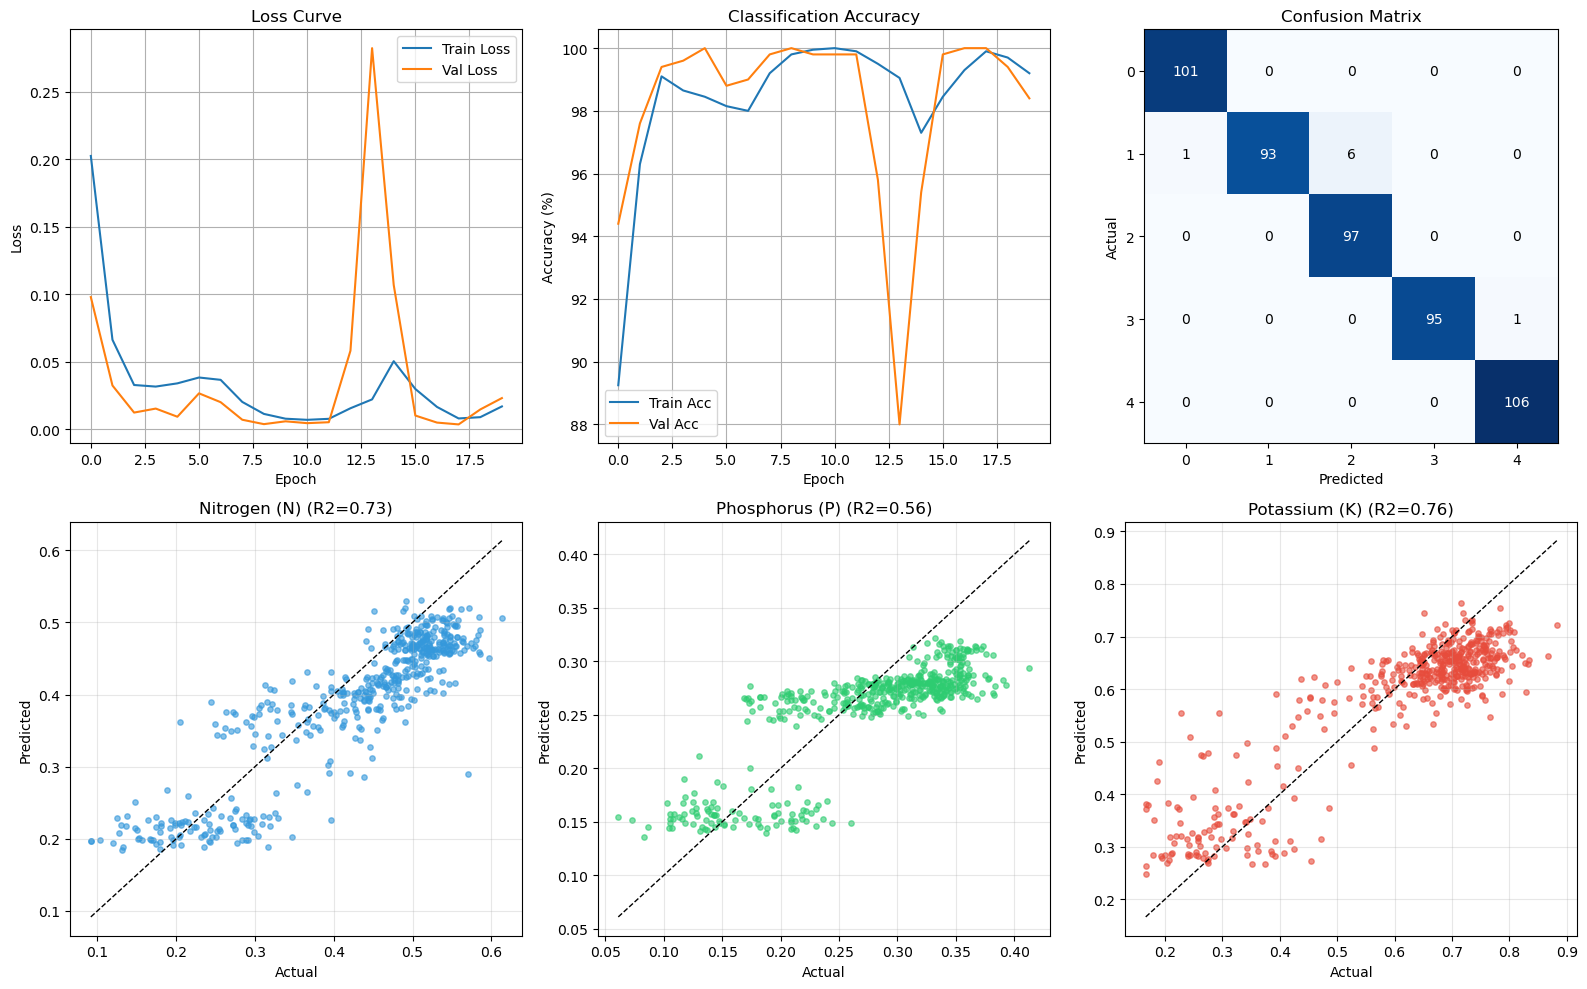

In [7]:
# [Cell] 모델 학습 실행 (GPU 사용)
import torch
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# train.py 실행
%run train.py

In [8]:
%%writefile service.py
import torch
import torch.nn.functional as F
from model import SmartFarmNet
from dataset import DISEASE_NAMES, NUM_CLASSES

# ==========================================
# 진단 서비스 (템플릿 기반 코멘트 생성)
# ==========================================
class DiagnosisService:
    def __init__(self):
        # 질병별 진단 정보 사전
        self.disease_info = {
            0: {
                "name": "정상",
                "severity": "good",
                "description": "작물이 건강한 상태입니다.",
                "advice": "현재 관리 방법을 유지하세요. 정기적인 관찰을 계속해주세요."
            },
            1: {
                "name": "잎끝마름(팁번)",
                "severity": "warning",
                "description": "잎 끝이 갈변하며 마르는 증상입니다. 주로 칼슘 흡수 장애나 급격한 환경 변화로 발생합니다.",
                "advice": "칼슘 엽면시비를 권장합니다. 급격한 온도/습도 변화를 피하고, 환기를 개선해주세요."
            },
            2: {
                "name": "황화",
                "severity": "warning", 
                "description": "잎이 노랗게 변색되는 증상입니다. 질소 결핍이나 철분 부족이 원인일 수 있습니다.",
                "advice": "질소 비료 추가 공급을 검토하세요. 철분 결핍 시 킬레이트 철 엽면시비가 효과적입니다."
            },
            3: {
                "name": "역병",
                "severity": "danger",
                "description": "곰팡이성 병해로 빠른 확산 위험이 있습니다. 잎과 줄기에 갈색 반점이 나타납니다.",
                "advice": "감염 부위를 즉시 제거하세요. 살균제 처리 및 환기 개선이 필요합니다. 주변 작물 관찰을 강화하세요."
            },
            4: {
                "name": "시들음병",
                "severity": "danger",
                "description": "뿌리/줄기 병해로 식물이 시들어갑니다. 토양 전염성 병해입니다.",
                "advice": "감염주를 격리하고 제거하세요. 토양 소독이 필요하며, 건전한 묘목으로 재식재를 검토하세요."
            }
        }
        
        # 심각도별 색상 (시각화용)
        self.severity_colors = {
            "good": "#27ae60",      # 녹색
            "warning": "#f39c12",   # 주황
            "danger": "#e74c3c"     # 빨강
        }
        
        # NPK 기준값 (딸기 적정 범위, ppm)
        self.npk_standards = {
            'N': {'low': 150, 'high': 200, 'unit': 'ppm'},
            'P': {'low': 100, 'high': 140, 'unit': 'ppm'},
            'K': {'low': 220, 'high': 260, 'unit': 'ppm'}
        }

    def analyze_results(self, pred_class_id, pred_npk, confidence):
        """
        AI 결과를 사람이 읽을 수 있는 데이터로 변환
        
        Args:
            pred_class_id: 예측된 질병 클래스 ID (0-4)
            pred_npk: 예측된 NPK 수치 [N, P, K] (정규화된 값 * 300)
            confidence: 분류 신뢰도 (0-1)
        
        Returns:
            dict: 분석 결과
        """
        disease = self.disease_info.get(pred_class_id, self.disease_info[0])
        
        # NPK 상태 분석
        n, p, k = pred_npk
        npk_status = []
        
        if n < self.npk_standards['N']['low']:
            npk_status.append(f"질소(N) 부족 ({n:.1f}ppm)")
        elif n > self.npk_standards['N']['high']:
            npk_status.append(f"질소(N) 과잉 ({n:.1f}ppm)")
            
        if p < self.npk_standards['P']['low']:
            npk_status.append(f"인산(P) 부족 ({p:.1f}ppm)")
        elif p > self.npk_standards['P']['high']:
            npk_status.append(f"인산(P) 과잉 ({p:.1f}ppm)")
            
        if k < self.npk_standards['K']['low']:
            npk_status.append(f"칼륨(K) 부족 ({k:.1f}ppm)")
        elif k > self.npk_standards['K']['high']:
            npk_status.append(f"칼륨(K) 과잉 ({k:.1f}ppm)")
        
        return {
            "disease_id": pred_class_id,
            "disease_name": disease["name"],
            "severity": disease["severity"],
            "severity_color": self.severity_colors[disease["severity"]],
            "description": disease["description"],
            "advice": disease["advice"],
            "confidence": confidence,
            "npk": {"N": n, "P": p, "K": k},
            "npk_status": npk_status if npk_status else ["NPK 수치 정상 범위"]
        }

    def generate_expert_comment(self, analysis_data, area_pyeong=300):
        """
        템플릿 기반 전문가 코멘트 생성
        
        Args:
            analysis_data: analyze_results()의 반환값
            area_pyeong: 재배 면적 (평)
        
        Returns:
            str: 전문가 코멘트
        """
        disease_name = analysis_data["disease_name"]
        severity = analysis_data["severity"]
        confidence = analysis_data["confidence"]
        description = analysis_data["description"]
        advice = analysis_data["advice"]
        npk = analysis_data["npk"]
        npk_status = analysis_data["npk_status"]
        
        # 심각도별 인사말
        if severity == "good":
            greeting = "좋은 소식입니다!"
        elif severity == "warning":
            greeting = "주의가 필요합니다."
        else:
            greeting = "긴급 조치가 필요합니다!"
        
        # 코멘트 조합
        comment = f"""
[AI 농사비서 진단 리포트]

{greeting}

진단 결과: {disease_name} (신뢰도: {confidence:.1%})
{description}

NPK 상태:
- 질소(N): {npk['N']:.1f}ppm
- 인산(P): {npk['P']:.1f}ppm  
- 칼륨(K): {npk['K']:.1f}ppm
- 상태: {', '.join(npk_status)}

권장 조치:
{advice}

재배 면적 {area_pyeong}평 기준으로 분석되었습니다.
정기적인 모니터링을 통해 작물 건강을 유지하세요!
        """.strip()
        
        return comment


# ==========================================
# 기존 FertilizerService (호환용)
# ==========================================
class FertilizerService:
    def __init__(self, inventory_path=None):
        self.std_kg = {'N': 6.1, 'P': 3.0, 'K': 1.8}

    def prescribe(self, pred_npk, area_pyeong):
        n, p, k = pred_npk
        ratio = area_pyeong / 300.0
        msg = f"[AI 진단] (면적: {area_pyeong}평)\n"
        msg += f"예측값: N:{n:.1f}, P:{p:.1f}, K:{k:.1f}\n"

        if n < 80:
            req = (self.std_kg['N'] * ratio) / 0.46
            msg += f"[질소 부족] '요소비료' 약 {req:.1f}kg 처방.\n"
        return msg


# ==========================================
# 테스트 실행
# ==========================================
if __name__ == "__main__":
    # 테스트용 데이터
    service = DiagnosisService()
    
    # 가상의 분석 결과
    analysis = service.analyze_results(
        pred_class_id=1,  # 잎끝마름
        pred_npk=[165.0, 118.0, 215.0],
        confidence=0.87
    )
    
    print("=" * 60)
    print("분석 결과:")
    print(f"  질병: {analysis['disease_name']}")
    print(f"  심각도: {analysis['severity']}")
    print(f"  NPK 상태: {analysis['npk_status']}")
    print("=" * 60)
    
    comment = service.generate_expert_comment(analysis, area_pyeong=200)
    print(comment)

Overwriting service.py


In [9]:
# !python3 -m pip install torch torchvision

In [11]:
# PyTorch CUDA 버전 설치 (GPU 사용을 위해 필수)
import sys
!{sys.executable} -m pip uninstall torch torchvision -y
!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# GPU 확인
import torch
print(f"\n✅ CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU를 사용할 수 없습니다. 커널을 재시작한 후 이 셀을 다시 실행하세요.")

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-linux_x86_64.whl (780.5 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp311-cp311-linux_x86_64.whl (7.3 MB)

✅ CUDA 사용 가능: True
✅ GPU: NVIDIA GeForce RTX 4090


/tmp/ipykernel_14758/116890569.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


경고: 한글 폰트를 찾을 수 없습니다. 영문으로 표시합니다.
SmartFarmNet 모델 로드 완료!
이미지 경로 인덱싱 중...
데이터 로딩 중... (총 3개)


100%|██████████| 3/3 [00:00<00:00, 5957.82it/s]


데이터셋 준비 완료!
클래스 분포:
  - 정상: 0개
  - 잎끝마름(팁번): 2개
  - 황화: 0개
  - 역병: 1개
  - 시들음병: 0개

SmartFarmNet Diagnosis Demo

[Sample 1]


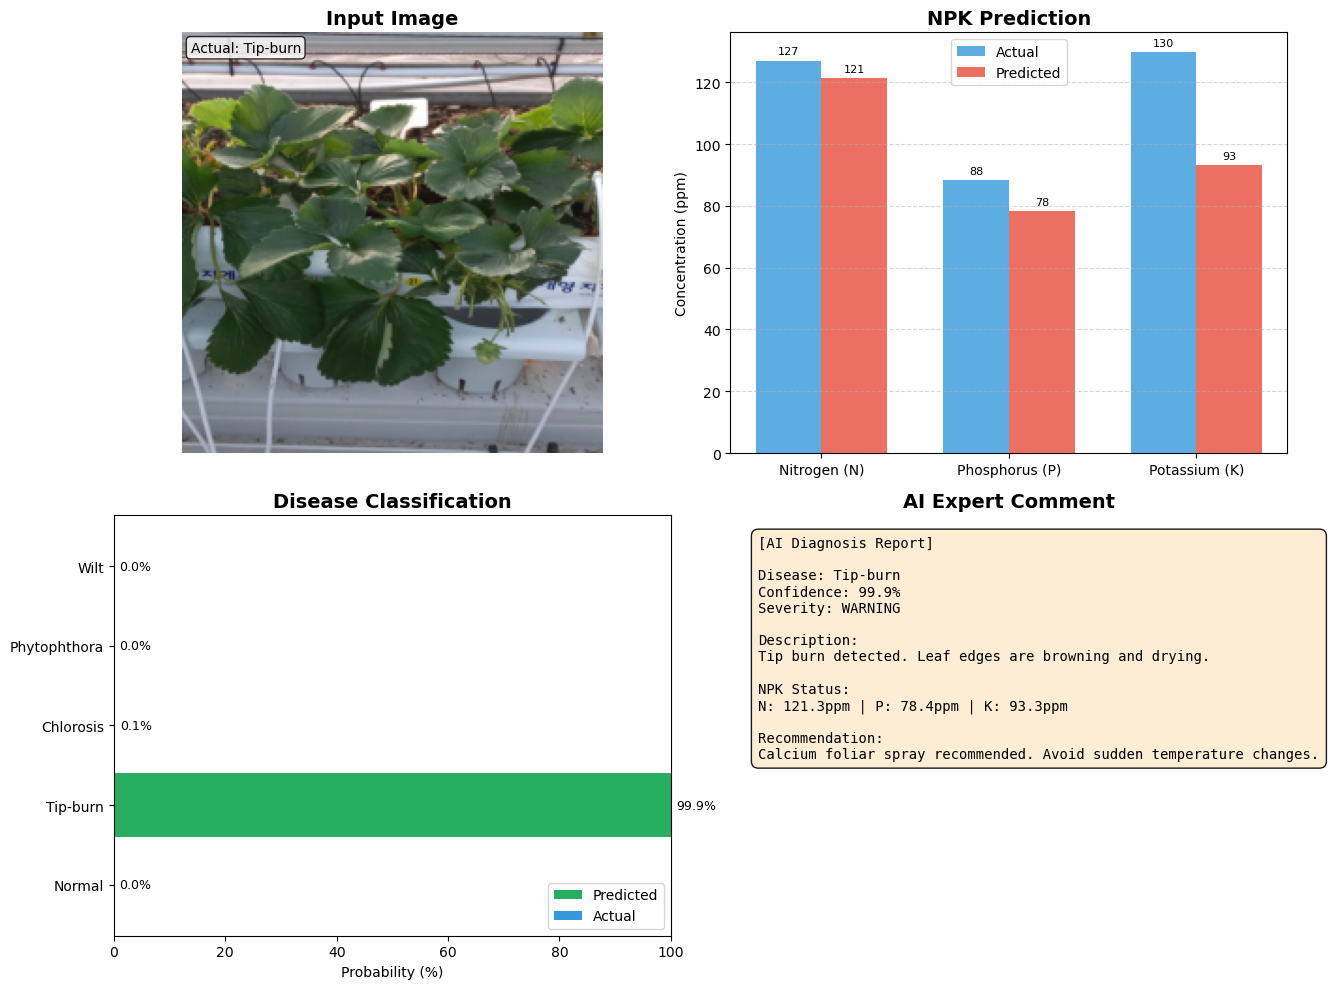


[Sensor Data]
  Temp: 25.0C | Humidity: 60.0% | CO2: 400ppm
  EC: 1.0 | pH: 6.0

[Prediction Result]
  Disease: 잎끝마름(팁번) (Tip-burn)
  Confidence: 99.9%
  Actual: 잎끝마름(팁번) (Tip-burn)
  Match: O

[Sample 2]


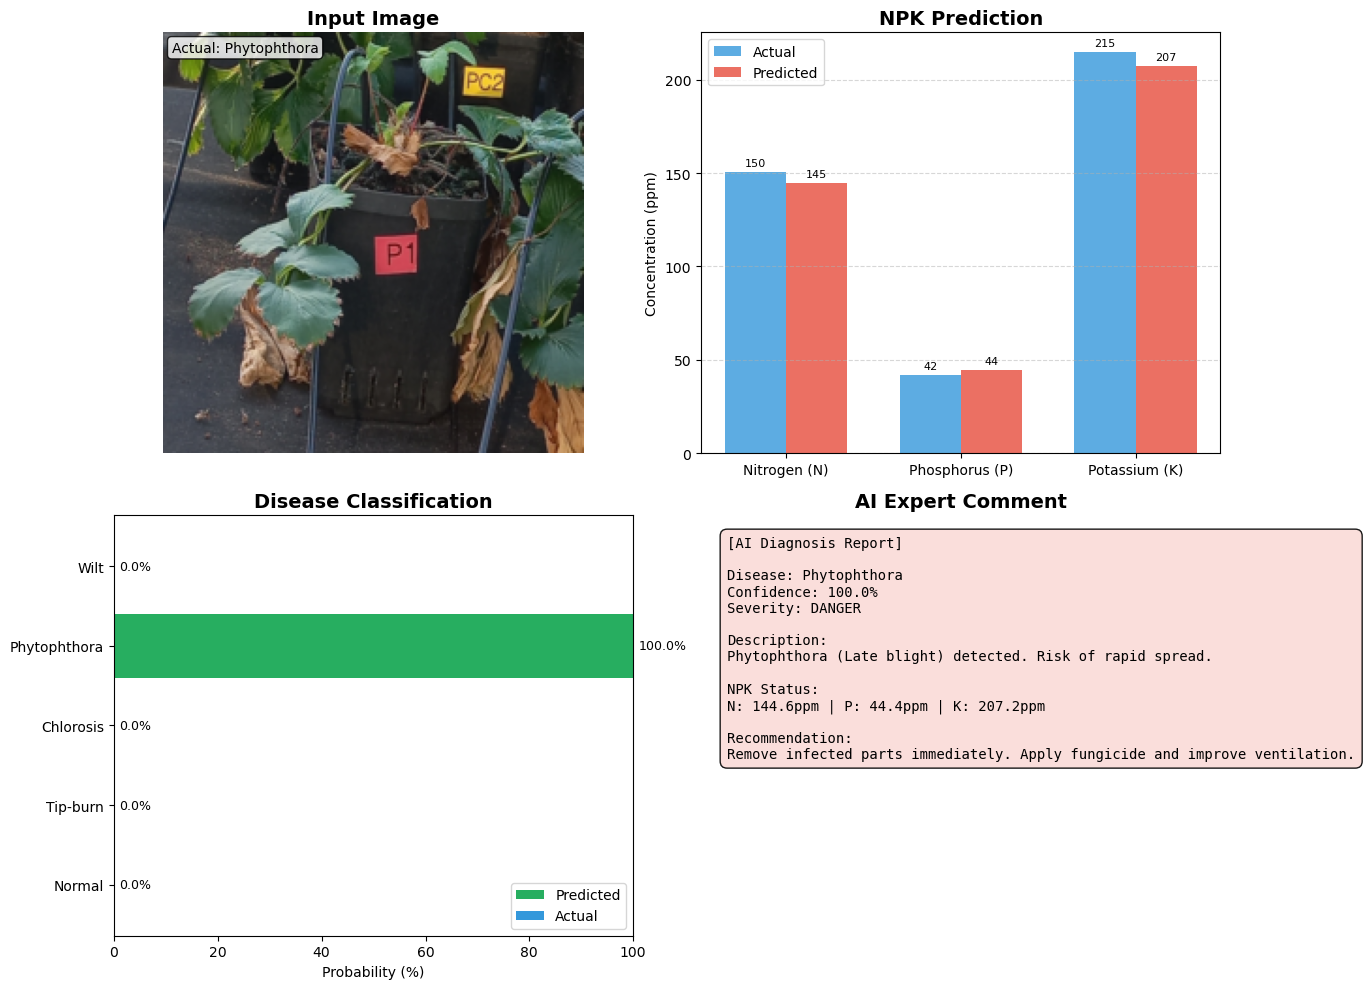


[Sensor Data]
  Temp: 24.2C | Humidity: 52.9% | CO2: 938ppm
  EC: 7.0 | pH: 6.2

[Prediction Result]
  Disease: 역병 (Phytophthora)
  Confidence: 100.0%
  Actual: 역병 (Phytophthora)
  Match: O

[Sample 3]


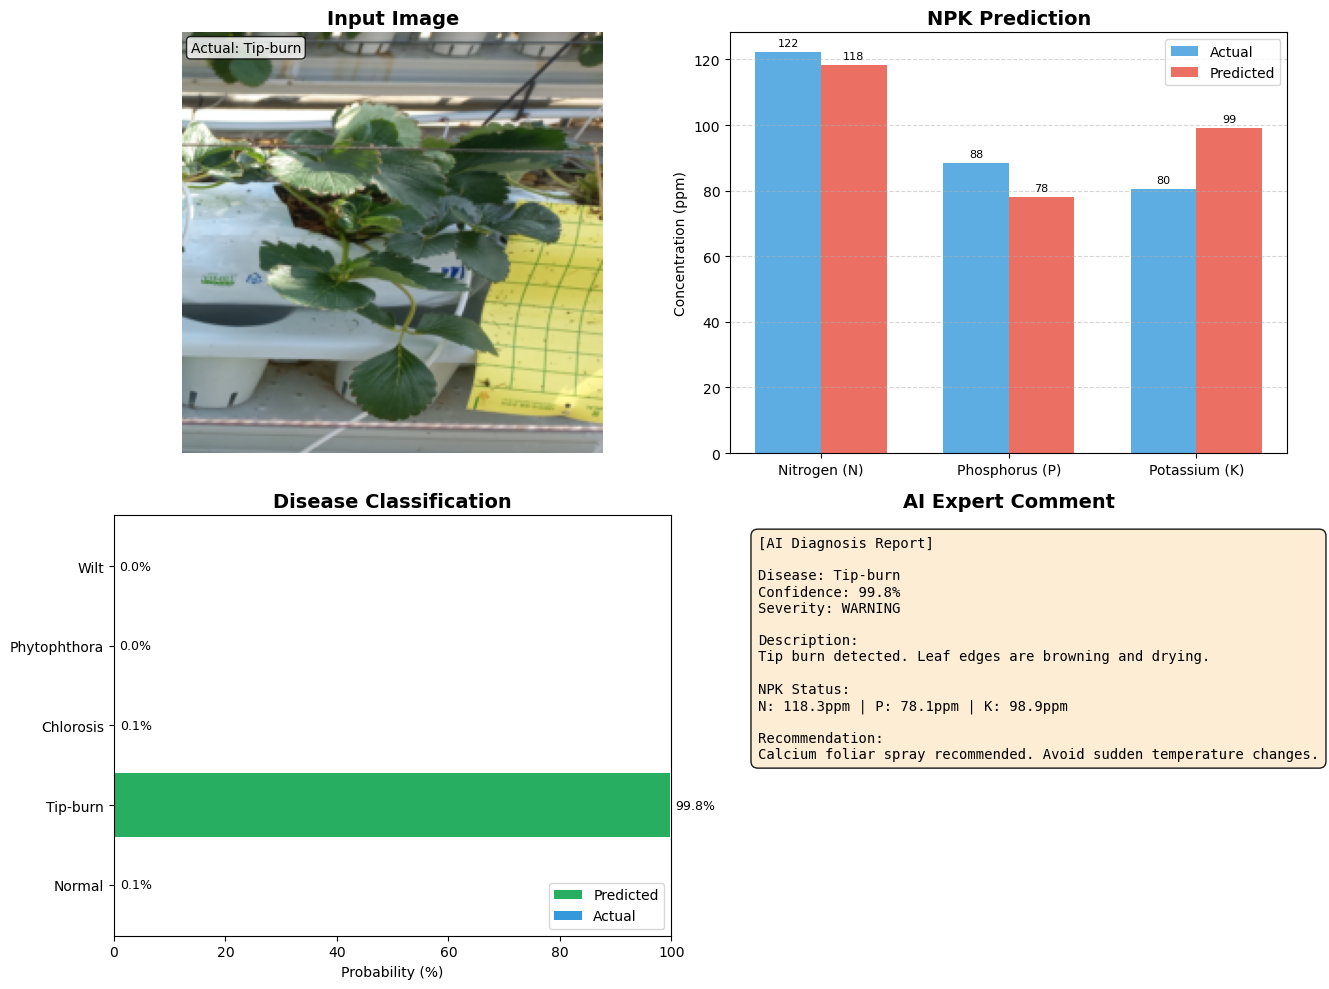


[Sensor Data]
  Temp: 25.0C | Humidity: 60.0% | CO2: 400ppm
  EC: 1.0 | pH: 6.0

[Prediction Result]
  Disease: 잎끝마름(팁번) (Tip-burn)
  Confidence: 99.8%
  Actual: 잎끝마름(팁번) (Tip-burn)
  Match: O



In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
import numpy as np
import torch
import torch.nn.functional as F
import glob
import os
import random
from torch.utils.data import DataLoader
from torchvision import transforms

# 모듈 임포트
from dataset import StrawberryDataset, DISEASE_NAMES, NUM_CLASSES
from model import SmartFarmNet
from service import DiagnosisService

# ==========================================
# 한글 폰트 설정
# ==========================================
# 시스템에서 사용 가능한 한글 폰트 찾기
def get_korean_font():
    """시스템에서 한글 폰트를 찾아서 설정"""
    font_candidates = [
        'NanumGothic',
        'NanumBarunGothic', 
        'Malgun Gothic',
        'AppleGothic',
        'UnDotum',
        'Noto Sans CJK KR',
        'Noto Sans KR',
        'Source Han Sans KR'
    ]
    
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    for font in font_candidates:
        if font in available_fonts:
            return font
    
    # 폰트를 찾지 못하면 None 반환
    return None

korean_font = get_korean_font()

if korean_font:
    plt.rcParams['font.family'] = korean_font
    print(f"한글 폰트 설정: {korean_font}")
else:
    # 한글 폰트가 없으면 영문으로 대체
    print("경고: 한글 폰트를 찾을 수 없습니다. 영문으로 표시합니다.")
    DISEASE_NAMES_EN = ['Normal', 'Tip-burn', 'Chlorosis', 'Phytophthora', 'Wilt']
    
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 설정 및 모델 로드
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/home/jovyan/work/metaorganic/smartfarm_model.pth'

# 새로운 SmartFarmNet 모델 로드
model = SmartFarmNet(num_sensor_features=8, num_classes=NUM_CLASSES).to(device)

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("SmartFarmNet 모델 로드 완료!")
else:
    print("모델 파일이 없습니다. train.py를 먼저 실행하세요.")

model.eval()

# 진단 서비스 초기화
diagnosis_service = DiagnosisService()

# 표시용 클래스 이름 (폰트 지원 여부에 따라)
DISPLAY_NAMES = DISEASE_NAMES if korean_font else ['Normal', 'Tip-burn', 'Chlorosis', 'Phytophthora', 'Wilt']

# ==========================================
# 2. 테스트 데이터 준비
# ==========================================
img_root = '/home/jovyan/work/metaorganic/data/images'
json_list = glob.glob('/home/jovyan/work/metaorganic/data/jsons/*.json')

random.shuffle(json_list)
sample_files = json_list[:3]

if not sample_files:
    print("데이터 파일이 없습니다. Cell 1을 먼저 실행하세요.")
else:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = StrawberryDataset(sample_files, img_root, transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # ==========================================
    # 3. 종합 진단 시각화 함수
    # ==========================================
    def visualize_diagnosis(img_tensor, sensors, pred_npk, pred_class_logits, true_npk, true_class):
        """종합 진단 결과를 시각화"""
        
        # 이미지 역정규화
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # 예측값 변환
        pred_npk_vals = pred_npk.cpu().numpy().flatten() * 300.0
        true_npk_vals = true_npk.cpu().numpy().flatten() * 300.0
        
        # 분류 결과
        probs = F.softmax(pred_class_logits, dim=1).cpu().numpy().flatten()
        pred_class_id = probs.argmax()
        confidence = probs[pred_class_id]
        true_class_id = true_class.item()
        
        # 진단 서비스 호출
        analysis = diagnosis_service.analyze_results(
            pred_class_id=pred_class_id,
            pred_npk=pred_npk_vals.tolist(),
            confidence=confidence
        )
        
        # ==========================================
        # 시각화 (2x2 레이아웃)
        # ==========================================
        fig = plt.figure(figsize=(14, 10))
        
        # --- (1) 입력 이미지 ---
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.imshow(img_np)
        ax1.set_title('Input Image', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # 실제 클래스 표시
        ax1.text(0.02, 0.98, f'Actual: {DISPLAY_NAMES[true_class_id]}',
                transform=ax1.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # --- (2) NPK 바 차트 ---
        ax2 = fig.add_subplot(2, 2, 2)
        labels = ['Nitrogen (N)', 'Phosphorus (P)', 'Potassium (K)']
        x = np.arange(len(labels))
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, true_npk_vals, width, label='Actual', color='#3498db', alpha=0.8)
        bars2 = ax2.bar(x + width/2, pred_npk_vals, width, label='Predicted', color='#e74c3c', alpha=0.8)
        
        ax2.set_ylabel('Concentration (ppm)')
        ax2.set_title('NPK Prediction', fontsize=14, fontweight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels(labels)
        ax2.legend()
        ax2.grid(axis='y', linestyle='--', alpha=0.5)
        ax2.bar_label(bars1, padding=3, fmt='%.0f', fontsize=8)
        ax2.bar_label(bars2, padding=3, fmt='%.0f', fontsize=8)
        
        # --- (3) 질병 분류 확률 ---
        ax3 = fig.add_subplot(2, 2, 3)
        colors = ['#27ae60' if i == pred_class_id else '#bdc3c7' for i in range(NUM_CLASSES)]
        colors[true_class_id] = '#3498db' if true_class_id != pred_class_id else '#27ae60'
        
        bars = ax3.barh(range(NUM_CLASSES), probs * 100, color=colors)
        ax3.set_yticks(range(NUM_CLASSES))
        ax3.set_yticklabels(DISPLAY_NAMES)
        ax3.set_xlabel('Probability (%)')
        ax3.set_title('Disease Classification', fontsize=14, fontweight='bold')
        ax3.set_xlim(0, 100)
        
        # 퍼센트 표시
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            ax3.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{prob*100:.1f}%', va='center', fontsize=9)
        
        # 범례
        legend_elements = [
            mpatches.Patch(facecolor='#27ae60', label='Predicted'),
            mpatches.Patch(facecolor='#3498db', label='Actual')
        ]
        ax3.legend(handles=legend_elements, loc='lower right')
        
        # --- (4) AI 코멘트 ---
        ax4 = fig.add_subplot(2, 2, 4)
        ax4.axis('off')
        
        # 심각도에 따른 배경색
        severity_bg = {
            'good': '#d5f5e3',
            'warning': '#fdebd0', 
            'danger': '#fadbd8'
        }
        bg_color = severity_bg.get(analysis['severity'], '#ffffff')
        
        # 영문 코멘트 (폰트 문제 방지)
        severity_text = {
            'good': 'HEALTHY',
            'warning': 'WARNING', 
            'danger': 'DANGER'
        }
        
        disease_desc_en = {
            0: "The crop is in healthy condition.",
            1: "Tip burn detected. Leaf edges are browning and drying.",
            2: "Chlorosis detected. Leaves are turning yellow.",
            3: "Phytophthora (Late blight) detected. Risk of rapid spread.",
            4: "Wilt disease detected. Root/stem infection causing wilting."
        }
        
        disease_advice_en = {
            0: "Maintain current management. Continue regular monitoring.",
            1: "Calcium foliar spray recommended. Avoid sudden temperature changes.",
            2: "Consider nitrogen fertilizer. Check for iron deficiency.",
            3: "Remove infected parts immediately. Apply fungicide and improve ventilation.",
            4: "Isolate and remove infected plants. Consider soil disinfection."
        }
        
        comment_text = f"""
[AI Diagnosis Report]

Disease: {DISPLAY_NAMES[pred_class_id]}
Confidence: {analysis['confidence']:.1%}
Severity: {severity_text.get(analysis['severity'], 'UNKNOWN')}

Description:
{disease_desc_en.get(pred_class_id, 'No description available.')}

NPK Status:
N: {analysis['npk']['N']:.1f}ppm | P: {analysis['npk']['P']:.1f}ppm | K: {analysis['npk']['K']:.1f}ppm

Recommendation:
{disease_advice_en.get(pred_class_id, 'No advice available.')}
        """.strip()
        
        ax4.text(0.05, 0.95, comment_text,
                transform=ax4.transAxes,
                fontsize=10,
                verticalalignment='top',
                fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=bg_color, alpha=0.9))
        
        ax4.set_title('AI Expert Comment', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 콘솔에 상세 정보 출력 (한글 지원)
        s_val = sensors.cpu().numpy().flatten()
        print(f"\n{'='*70}")
        print(f"[Sensor Data]")
        print(f"  Temp: {s_val[0]:.1f}C | Humidity: {s_val[1]:.1f}% | CO2: {s_val[2]:.0f}ppm")
        print(f"  EC: {s_val[3]:.1f} | pH: {s_val[4]:.1f}")
        print(f"\n[Prediction Result]")
        print(f"  Disease: {DISEASE_NAMES[pred_class_id]} ({DISPLAY_NAMES[pred_class_id]})")
        print(f"  Confidence: {confidence:.1%}")
        print(f"  Actual: {DISEASE_NAMES[true_class_id]} ({DISPLAY_NAMES[true_class_id]})")
        print(f"  Match: {'O' if pred_class_id == true_class_id else 'X'}")
        print(f"{'='*70}\n")

    # ==========================================
    # 4. 실행
    # ==========================================
    print("\n" + "="*70)
    print("SmartFarmNet Diagnosis Demo")
    print("="*70 + "\n")
    
    with torch.no_grad():
        for i, (img, sensors, target_npk, target_cls) in enumerate(dataloader):
            img = img.to(device)
            sensors = sensors.to(device)
            
            # 듀얼 헤드 출력
            pred_npk, pred_cls = model(img, sensors)
            
            print(f"[Sample {i+1}]")
            visualize_diagnosis(
                img_tensor=img[0],
                sensors=sensors,
                pred_npk=pred_npk,
                pred_class_logits=pred_cls,
                true_npk=target_npk,
                true_class=target_cls
            )